<a href="https://colab.research.google.com/github/DeanHazineh/Emergent-World-Representations-Othello/blob/main/dev_code2/Othello_GPT_TransformerLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an interactive colab Notebook to do mechanistic interpretability on the Othello GPT based on Neel Nanda's TransformerLens library.


# Setup (Skip Reading)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    %pip install circuitsvis
    
    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-rn1_t9gm
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-rn1_t9gm
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit b26260cfbae46513236b20107d01f35b6163dc1b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [3]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")

In [4]:
!pip install torchtyping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [7]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [62]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0,labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [66]:
# Mech Interp Utils Setup
import os
import math
import time
from tqdm import tqdm
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
from torch.nn import functional as F
from functools import partial


torch.set_grad_enabled(True)
# %%


# %%

# A class to calculate the Othello Board State, shamelessly ripped from Kenneth Li's code base

rows = list("abcdefgh")
columns = [str(_) for _ in range(1, 9)]

def permit(s):
    s = s.lower()
    if len(s) != 2:
        return -1
    if s[0] not in rows or s[1] not in columns:
        return -1
    return rows.index(s[0]) * 8 + columns.index(s[1])

def permit_reverse(integer):
    r, c = integer // 8, integer % 8
    return "".join([rows[r], columns[c]])

start_hands = [permit(_) for _ in ["d5", "d4", "e4", "e5"]]
eights = [[-1, 0], [-1, 1], [0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1]]


class OthelloBoardState():
    # 1 is black, -1 is white
    def __init__(self, board_size = 8):
        self.board_size = board_size * board_size
        board = np.zeros((8, 8))
        board[3, 4] = 1
        board[3, 3] = -1
        board[4, 3] = 1
        board[4, 4] = -1
        self.initial_state = board
        self.state = self.initial_state
        self.age = np.zeros((8, 8))
        self.next_hand_color = 1
        self.history = []

    def get_occupied(self, ):
        board = self.state
        tbr = board.flatten() != 0
        return tbr.tolist()
    def get_state(self, ):
        board = self.state + 1  # white 0, blank 1, black 2
        tbr = board.flatten()
        return tbr.tolist()
    def get_age(self, ):
        return self.age.flatten().tolist()
    def get_next_hand_color(self, ):
        return (self.next_hand_color + 1) // 2
    
    def update(self, moves, prt=False):
        # takes a new move or new moves and update state
        if prt:
            self.__print__()
        for _, move in enumerate(moves):
            self.umpire(move)
            if prt:
                self.__print__()

    def umpire(self, move):
        r, c = move // 8, move % 8
        assert self.state[r, c] == 0, f"{r}-{c} is already occupied!"
        occupied = np.sum(self.state != 0)
        color = self.next_hand_color
        tbf = []
        for direction in eights:
            buffer = []
            cur_r, cur_c = r, c
            while 1:
                cur_r, cur_c = cur_r + direction[0], cur_c + direction[1]
                if cur_r < 0  or cur_r > 7 or cur_c < 0 or cur_c > 7:
                    break
                if self.state[cur_r, cur_c] == 0:
                    break
                elif self.state[cur_r, cur_c] == color:
                    tbf.extend(buffer)
                    break
                else:
                    buffer.append([cur_r, cur_c])
        if len(tbf) == 0:  # means one hand is forfeited
            # print(f"One {color} move forfeited")
            color *= -1
            self.next_hand_color *= -1
            for direction in eights:
                buffer = []
                cur_r, cur_c = r, c
                while 1:
                    cur_r, cur_c = cur_r + direction[0], cur_c + direction[1]
                    if cur_r < 0  or cur_r > 7 or cur_c < 0 or cur_c > 7:
                        break
                    if self.state[cur_r, cur_c] == 0:
                        break
                    elif self.state[cur_r, cur_c] == color:
                        tbf.extend(buffer)
                        break
                    else:
                        buffer.append([cur_r, cur_c])
        if len(tbf) == 0:
            valids = self.get_valid_moves()
            if len(valids) == 0:
                assert 0, "Both color cannot put piece, game should have ended!"
            else:
                assert 0, "Illegal move!"
                
        self.age += 1
        for ff in tbf:
            self.state[ff[0], ff[1]] *= -1
            self.age[ff[0], ff[1]] = 0
        self.state[r, c] = color
        self.age[r, c] = 0
        self.next_hand_color *= -1
        self.history.append(move)
        
    def __print__(self, ):
        print("-"*20)
        print([permit_reverse(_) for _ in self.history])
        a = "abcdefgh"
        for k, row in enumerate(self.state.tolist()):
            tbp = []
            for ele in row:
                if ele == -1:
                    tbp.append("O")
                elif ele == 0:
                    tbp.append(" ")
                else:
                    tbp.append("X")
            # tbp.append("\n")
            print(" ".join([a[k]] + tbp))
        tbp = [str(k) for k in range(1, 9)]
        print(" ".join([" "] + tbp))
        print("-"*20)
        
    def tentative_move(self, move):
        # tentatively put a piece, do nothing to state
        # returns 0 if this is not a move at all: occupied or both player have to forfeit
        # return 1 if regular move
        # return 2 if forfeit happens but the opponent can drop piece at this place
        r, c = move // 8, move % 8
        if not self.state[r, c] == 0:
            return 0
        occupied = np.sum(self.state != 0)
        color = self.next_hand_color
        tbf = []
        for direction in eights:
            buffer = []
            cur_r, cur_c = r, c
            while 1:
                cur_r, cur_c = cur_r + direction[0], cur_c + direction[1]
                if cur_r < 0  or cur_r > 7 or cur_c < 0 or cur_c > 7:
                    break
                if self.state[cur_r, cur_c] == 0:
                    break
                elif self.state[cur_r, cur_c] == color:
                    tbf.extend(buffer)
                    break
                else:
                    buffer.append([cur_r, cur_c])
        if len(tbf) != 0:
            return 1
        else:  # means one hand is forfeited
            # print(f"One {color} move forfeited")
            color *= -1
            # self.next_hand_color *= -1
            for direction in eights:
                buffer = []
                cur_r, cur_c = r, c
                while 1:
                    cur_r, cur_c = cur_r + direction[0], cur_c + direction[1]
                    if cur_r < 0  or cur_r > 7 or cur_c < 0 or cur_c > 7:
                        break
                    if self.state[cur_r, cur_c] == 0:
                        break
                    elif self.state[cur_r, cur_c] == color:
                        tbf.extend(buffer)
                        break
                    else:
                        buffer.append([cur_r, cur_c])
            if len(tbf) == 0:
                return 0
            else:
                return 2
        
    def get_valid_moves(self, ):
        regular_moves = []
        forfeit_moves = []
        for move in range(64):
            x = self.tentative_move(move)
            if x == 1:
                regular_moves.append(move)
            elif x == 2:
                forfeit_moves.append(move)
            else:
                pass
        if len(regular_moves):
            return regular_moves
        elif len(forfeit_moves):
            return forfeit_moves
        else:
            return []
 
    def get_gt(self, moves, func, prt=False):
        # takes a new move or new moves and update state
        container = []
        if prt:
            self.__print__()
        for _, move in enumerate(moves):
            self.umpire(move)
            container.append(getattr(self, func)())  
            # to predict first y, we need already know the first x
            if prt:
                self.__print__()
        return container

    def plot_hm(self, ax, heatmap, pdmove, logit=False):
        padding = np.array([0.0, 0.0])
        trs = {-1: r"O", 0: " ", 1: r"X"}
        if len(heatmap) == 60:
            heatmap = [heatmap[:27], padding, heatmap[27:33], padding, heatmap[33:]]
            heatmap = np.concatenate(heatmap)
        assert len(heatmap) == 64
        heatmap = np.array(heatmap).reshape(8, 8)
        annot = [trs[_] for _ in self.state.flatten().tolist()]
        cloned = deepcopy(self)
        cloned.update(
            [
                pdmove,
            ]
        )

        next_color = 1 - cloned.get_next_hand_color()
        annot[pdmove] = ("\\underline{" + (trs[next_color * 2 - 1]) + "}")[-13:]

        color = {-1: "white", 0: "grey", 1: "black"}
        ann_col = [color[_] for _ in self.state.flatten().tolist()]
        # ann_col[pdmove] = color[next_color * 2 -1]
        text_for_next_color = color[next_color * 2 - 1].capitalize()
# # %%
# try:
#     othello
#     print("Othello dataset exists")

# except:
#     print("Making dataset")
#     othello = get_othello(ood_num=-1, data_root=None, wthor=True)
#     train_dataset = CharDataset(othello)

# # made_othello=True
# # %%
# full_seqs = list(filter(lambda x: len(x)==60, train_dataset.data.sequences))
# print(len(full_seqs))
# board_seqs = torch.tensor(full_seqs)
# print(board_seqs.numel())
# # %%
# # n = 50000
# # board_seqs = torch.zeros((n, 60), dtype=int)
# # for c, seq in enumerate(tqdm(othello.sequences)):
# #     board_seqs[c, :len(seq)] = torch.tensor(seq)
# #     if c == n-1:
# #         break
# # %%
# board_seqs_string = board_seqs
# print(board_seqs_string.numel())
# # %%
# board_seqs_int = board_seqs_string.clone()
# board_seqs_int[board_seqs_string < 29] += 1
# board_seqs_int[(board_seqs_string >= 29) & (board_seqs_string <= 34)] -= 1
# board_seqs_int[(board_seqs_string > 34)] -= 3
# rand = torch.randint(0, 1000000, (20,))
# print(board_seqs_int.flatten()[rand])
# print(board_seqs_string.flatten()[rand])
# # torch.save(board_seqs, "board_seqs.pt")
# # %%
# indices = torch.randperm(len(board_seqs_int))
# board_seqs_int = board_seqs_int[indices]
# board_seqs_string = board_seqs_string[indices]
# torch.save(board_seqs_int, "board_seqs_int.pth")
# torch.save(board_seqs_string, "board_seqs_string.pth")
# %%
# board_seqs_int = torch.load("board_seqs_int.pth")
# board_seqs_string = torch.load("board_seqs_string.pth")
# print(board_seqs_int.shape)
#imshow(board_seqs_int[0,:5], title="Board Seqs Int Test")
# imshow(board_seqs_string[:5], title="Board Seqs String Test")
# %%
itos = {
    0: -100,
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 6,
    8: 7,
    9: 8,
    10: 9,
    11: 10,
    12: 11,
    13: 12,
    14: 13,
    15: 14,
    16: 15,
    17: 16,
    18: 17,
    19: 18,
    20: 19,
    21: 20,
    22: 21,
    23: 22,
    24: 23,
    25: 24,
    26: 25,
    27: 26,
    28: 29,
    29: 30,
    30: 31,
    31: 32,
    32: 33,
    33: 34,
    34: 37,
    35: 38,
    36: 39,
    37: 40,
    38: 41,
    39: 42,
    40: 43,
    41: 44,
    42: 45,
    43: 46,
    44: 47,
    45: 48,
    46: 49,
    47: 50,
    48: 51,
    49: 52,
    50: 53,
    51: 54,
    52: 55,
    53: 56,
    54: 57,
    55: 58,
    56: 59,
    57: 60,
    58: 61,
    59: 62,
    60: 63,
}

stoi = {
    -100: 0,
    -1: 0,
    0: 1,
    1: 2,
    2: 3,
    3: 4,
    4: 5,
    5: 6,
    6: 7,
    7: 8,
    8: 9,
    9: 10,
    10: 11,
    11: 12,
    12: 13,
    13: 14,
    14: 15,
    15: 16,
    16: 17,
    17: 18,
    18: 19,
    19: 20,
    20: 21,
    21: 22,
    22: 23,
    23: 24,
    24: 25,
    25: 26,
    26: 27,
    29: 28,
    30: 29,
    31: 30,
    32: 31,
    33: 32,
    34: 33,
    37: 34,
    38: 35,
    39: 36,
    40: 37,
    41: 38,
    42: 39,
    43: 40,
    44: 41,
    45: 42,
    46: 43,
    47: 44,
    48: 45,
    49: 46,
    50: 47,
    51: 48,
    52: 49,
    53: 50,
    54: 51,
    55: 52,
    56: 53,
    57: 54,
    58: 55,
    59: 56,
    60: 57,
    61: 58,
    62: 59,
    63: 60,
}
# %%
stoi_indices = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    29,
    30,
    31,
    32,
    33,
    34,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
]
alpha = "ABCDEFGH"


def to_board_label(i):
    return f"{alpha[i//8]}{i%8}"


board_labels = list(map(to_board_label, stoi_indices))
# %%
def str_to_int(s):
    return stoi[s] - 1


def to_int(x):
    # print("\t", x)
    if isinstance(x, torch.Tensor) and x.numel() == 1:
        return to_int(x.item())
    elif (
        isinstance(x, list) or isinstance(x, torch.Tensor) or isinstance(x, np.ndarray)
    ):
        return [to_int(i) for i in x]
    elif isinstance(x, int):
        return stoi[x]
    elif isinstance(x, str):
        x = x.upper()
        return to_int(to_string(x))


def to_string(x):
    """Confusingly, maps it to an int, but a board pos label not a token label (token labels have 0 == pass, and middle board cells don't exist)"""
    # print("\t", x)
    if isinstance(x, torch.Tensor) and x.numel() == 1:
        return to_string(x.item())
    elif (
        isinstance(x, list) or isinstance(x, torch.Tensor) or isinstance(x, np.ndarray)
    ):
        return [to_string(i) for i in x]
    elif isinstance(x, int):
        return itos[x]
    elif isinstance(x, str):
        x = x.upper()
        return 8 * alpha.index(x[0]) + int(x[1])


def to_label(x, from_int=True):
    # print("\t", x)
    if isinstance(x, torch.Tensor) and x.numel() == 1:
        return to_label(x.item(), from_int=from_int)
    elif (
        isinstance(x, list) or isinstance(x, torch.Tensor) or isinstance(x, np.ndarray)
    ):
        return [to_label(i, from_int=from_int) for i in x]
    elif isinstance(x, int):
        if from_int:
            return to_board_label(to_string(x))
        else:
            return to_board_label(x)
    elif isinstance(x, str):
        return x


int_to_label = to_label
string_to_label = partial(to_label, from_int=False)
str_to_label = string_to_label

def moves_to_state(moves):
    # moves is a list of string entries (ints)
    state = np.zeros((8, 8), dtype=bool)
    for move in moves:
        state[move // 8, move % 8] = 1.0
    return state

int_labels = (
    list(range(1, 28))
    + ["X", "X"]
    + list(range(28, 34))
    + ["X", "X"]
    + list(range(34, 61))
)

# %%

def get_valid_moves(sequence):
    if isinstance(sequence, torch.Tensor):
        sequence = sequence.tolist()
    board = OthelloBoardState()
    return board.get_gt(sequence, "get_valid_moves")


# get_valid_moves(board_seqs_string[0])
# %%
def make_plot_state(board):
    state = np.copy(board.state).flatten()
    valid_moves = board.get_valid_moves()
    next_move = board.get_next_hand_color()
    # print(next_move, valid_moves)
    for move in valid_moves:
        state[move] = next_move - 0.5
    return state


def add_counter(fig, position, color):
    is_black = color > 0
    row = position // 8
    col = position % 8
    fig.layout.shapes += (
        dict(
            type="circle",
            x0=col - 0.2,
            y0=row - 0.2,
            x1=col + 0.2,
            y1=row + 0.2,
            fillcolor="black" if is_black else "white",
            line_color="green",
            line_width=0.5,
        ),
    )
    return fig


def counter_shape(position, color, mode="normal"):
    is_black = color > 0
    row = position // 8
    col = position % 8
    shape = dict(
        type="circle",
        fillcolor="black" if is_black else "white",
    )
    if mode == "normal":
        shape.update(
            x0=col - 0.2,
            y0=row - 0.2,
            x1=col + 0.2,
            y1=row + 0.2,
            line_color="green",
            line_width=0.5,
        )
    elif mode == "flipped":
        shape.update(
            x0=col - 0.22,
            y0=row - 0.22,
            x1=col + 0.22,
            y1=row + 0.22,
            line_color="purple",
            line_width=3,
        )
    elif mode == "new":
        shape.update(
            line_color="red",
            line_width=4,
            x0=col - 0.25,
            y0=row - 0.25,
            x1=col + 0.25,
            y1=row + 0.25,
        )
    return shape


def plot_board(moves, return_fig=False):
    if isinstance(moves, torch.Tensor):
        moves = moves.tolist()
    if isinstance(moves[0], str):
        moves = to_string(moves)
    board = OthelloBoardState()
    states = []
    states.append(make_plot_state(board))
    for move in moves:
        board.umpire(move)
        states.append(make_plot_state(board))
    states = np.stack(states, axis=0)
    fig = imshow(
        states.reshape(-1, 8, 8),
        color_continuous_scale="Geyser",
        aspect="equal",
        #return_figure=True,
        animation_frame=0,
        y=["a", "b", "c", "d", "e", "f", "g", "h"],
        x=["0", "1", "2", "3", "4", "5", "6", "7"],
        #animation_index=[
         #   f"{i+1} ({'W' if i%2==0 else 'B'}) [{to_board_label(moves[i]) if i>=0 else 'X'} -> {to_board_label(moves[i+1]) if i<len(moves)-1 else 'X'}]"
          #  for i in range(-1, len(moves))
        #],
        #animation_name="Move",
    )
    fig = fig.update_layout(title_x=0.5)
    fig.update_traces(
        text=[[str(i + 8 * j) for i in range(8)] for j in range(8)],
        texttemplate="%{text}",
    )
    for c, frame in enumerate(fig.frames):
        for i in range(64):
            if states[c].flatten()[i] == 1:
                frame = add_counter(frame, i, True)
            elif states[c].flatten()[i] == -1:
                frame = add_counter(frame, i, False)
    fig.layout.shapes = fig.frames[0].layout.shapes
    if return_fig:
        return fig
    else:
        fig.show()



# %%
def add_ring(fig, position, color):
    is_black = color > 0
    row = position // 8
    col = position % 8
    offset = 0.3
    fig.layout.shapes += (
        dict(
            type="rect",
            x0=col - offset,
            y0=row - offset,
            x1=col + offset,
            y1=row + offset,
            line_color="black" if is_black else "red",
            line_width=5,
            fillcolor=None,
        ),
    )
    return fig


def plot_board_log_probs(moves, logits, return_fig=False, use_counters=False):
    logits = logits.squeeze(0)
    if isinstance(moves, torch.Tensor):
        moves = moves.tolist()
    if isinstance(moves[0], str):
        moves = to_string(moves)
    # print(moves)
    assert len(moves) == len(logits)
    board = OthelloBoardState()
    states = []
    # states.append(make_plot_state(board))
    for move in moves:
        board.umpire(move)
        states.append(make_plot_state(board))
    states = np.stack(states, axis=0)

    log_probs = logits.log_softmax(dim=-1)
    log_probs_template = torch.zeros((len(moves), 64)).cuda() - 100
    if log_probs.shape[-1] == 61:
        log_probs_template[:, stoi_indices] = log_probs[:, 1:]
    else:
        log_probs_template[:, stoi_indices] = log_probs[:, :]
    log_probs_template = log_probs_template.reshape(-1, 8, 8)

    fig = imshow(
        log_probs_template,
        color_continuous_scale="Blues",
        zmin=-6.0,
        zmax=0.0,
        aspect="equal",
        return_fig=True,
        animation_frame=0,
        y=["a", "b", "c", "d", "e", "f", "g", "h"],
        x=["0", "1", "2", "3", "4", "5", "6", "7"],
        animation_index=[
            f"{i+1} ({'W' if i%2==0 else 'B'}) [{to_board_label(moves[i])} -> {to_board_label(moves[i+1]) if i<len(moves)-1 else 'X'}]"
            for i in range(len(moves))
        ],
        animation_name="Move",
    )
    fig = fig.update_layout(title_x=0.5)
    # fig.update_traces(text=[[str(i+8*j) for i in range(8)] for j in range(8)], texttemplate="%{text}")
    for c, frame in enumerate(tqdm(fig.frames)):
        text = []
        shapes = []
        for i in range(64):
            text.append("")
            counter_text = "O" if moves[c] != i else "X"
            if states[c].flatten()[i] == 1:
                if use_counters:
                    shapes.append(counter_shape(i, True))
                else:
                    # black = red
                    text[
                        -1
                    ] = f"<b style='font-size: 24em; color: red; '>{counter_text}</b>"
            elif states[c].flatten()[i] == -1:
                if use_counters:
                    shapes.append(counter_shape(i, False))
                else:
                    # white = green
                    text[
                        -1
                    ] = f"<b style='font-size: 24em; color: green;'>{counter_text}</b>"
            else:
                if states[c].flatten()[i] > 0.2:
                    text[
                        -1
                    ] = f"<span style='font-size: 12em; '>{to_board_label(i)}</span>"
                    # print(i, c, "b")
                    # frame = add_ring(frame, i, True)
                elif states[c].flatten()[i] < -0.2:
                    text[
                        -1
                    ] = f"<span style='font-size: 12em; color: white'>{to_board_label(i)}</span>"
                    # print(i, c, "w")
                    # frame = add_ring(frame, i, False)
        frame.layout.shapes = tuple(shapes)
        frame.data[0]["text"] = np.array(text).reshape(8, 8)
        frame.data[0]["texttemplate"] = "%{text}"
        frame.data[0][
            "hovertemplate"
        ] = "<b>%{y}%{x}</b><br>log prob: %{z}<br>prob=%{customdata}<extra></extra>"
        frame.data[0]["customdata"] = to_numpy(log_probs_template[c].exp())
    # print(states)
    fig.layout.shapes = fig.frames[0].layout.shapes
    fig.data[0]["text"] = fig.frames[0].data[0]["text"]
    fig.data[0]["texttemplate"] = fig.frames[0].data[0]["texttemplate"]
    fig.data[0]["customdata"] = fig.frames[0].data[0]["customdata"]
    fig.data[0]["hovertemplate"] = fig.frames[0].data[0]["hovertemplate"]
    if return_fig:
        return fig
    else:
        fig.show()

def plot_single_board(moves, model=None, return_fig=False, title=None):
    # moves is a list of string entries (ints)
    if isinstance(moves, torch.Tensor):
        moves = moves.tolist()
    if isinstance(moves[0], str):
        moves = to_string(moves)
    board = OthelloBoardState()
    if len(moves) > 1:
        board.update(moves[:-1])

    prev_state = np.copy(board.state)
    prev_player = board.next_hand_color
    prev_valid_moves = board.get_valid_moves()
    board.umpire(moves[-1])
    next_state = np.copy(board.state)
    next_player = board.next_hand_color
    next_valid_moves = board.get_valid_moves()

    empty = (prev_state == 0) & (next_state == 0)
    new = (prev_state == 0) & (next_state != 0)
    flipped = (prev_state != 0) & (next_state != prev_state) & (~new)
    prev_valid = moves_to_state(prev_valid_moves)
    next_valid = moves_to_state(next_valid_moves)

    state = np.copy(next_state)
    state[flipped] *= 0.9
    state[prev_valid] = 0.1 * prev_player
    state[next_valid] = 0.5 * next_player
    state[new] = 0.9 * prev_player
    if model is not None:
        logits = model(torch.tensor(to_int(moves)).cuda().unsqueeze(0)).cpu()
        log_probs = logits.log_softmax(-1)
        lps = torch.zeros(64) - 15.0
        lps[stoi_indices] = log_probs[0, -1, 1:]

    if title is None:
        title = f"{'Black' if prev_player!=1 else 'White'} To Play. Board State After {'Black' if prev_player==1 else 'White'} Plays {to_label(moves[-1], from_int=False)} "

    fig = imshow(
        state,
        color_continuous_scale="Geyser",
        title=title,
        y=[i for i in alpha],
        x=[str(i) for i in range(8)],
        aspect="equal",
        return_fig=True,
    )
    fig = fig.update_layout(title_x=0.5)
    fig.data[0]["hovertemplate"] = "<b>%{y}%{x}</b><br>%{customdata}<extra></extra>"

    shapes = []
    texts = []
    for i in range(64):
        texts.append("")
        if empty.flatten()[i]:
            texts[-1] = to_label(i, from_int=False)
        elif flipped.flatten()[i]:
            shapes.append(counter_shape(i, prev_player == 1, mode="flipped"))
        elif new.flatten()[i]:
            shapes.append(counter_shape(i, prev_player == 1, mode="new"))
        elif prev_state.flatten()[i] != 0:
            shapes.append(counter_shape(i, prev_state.flatten()[i] == 1, mode="normal"))
        else:
            raise ValueError(i)
    fig.layout.shapes = tuple(shapes)
    fig.data[0]["text"] = np.array(texts).reshape(8, 8)
    fig.data[0]["texttemplate"] = "%{text}"
    if model is not None:
        fig.data[0]["customdata"] = np.array(
            [f"LP:{lps[i].item():.4f}<br>I:{int_labels[i]}<br>S:{i}" for i in range(64)]
        ).reshape(8, 8)
    else:
        fig.data[0]["customdata"] = np.array(
            [f"I:{int_labels[i]}<br>S:{i}" for i in range(64)]
        ).reshape(8, 8)

    if return_fig:
        return fig
    else:
        fig.show()
    return

# %%
# def one_hot(list_of_ints, num_classes=64):
#     out = torch.zeros((num_classes,), dtype=torch.float32)
#     out[list_of_ints] = 1.
#     return out
# offset = 4123456
# num_games = 2000
# games_int = board_seqs_int[offset:offset+num_games]
# games_str = board_seqs_string[offset:offset+num_games]
# big_states = np.zeros((num_games, 59, 8, 8), dtype=np.float32)
# big_valid_moves = torch.zeros((num_games, 59, 64), dtype=torch.float32)
# for i in tqdm(range(num_games)):
#     board = OthelloBoardState()
#     for j in range(59):
#         board.umpire(games_str[i][j])
#         big_states[i][j] = board.state
#         big_valid_moves[i][j] = one_hot(board.get_valid_moves())
# big_valid_moves = einops.rearrange(big_valid_moves, "num_games pos (r c) -> num_games pos r c", r=8, c=8)
# # %%
# big_othello_state_dict = {
#     "big_states": big_states,
#     "big_valid_moves": big_valid_moves,
#     "offset": offset,
#     "games_str": games_str,
#     "games_int": games_int,
# }
# torch.save(big_othello_state_dict, "/workspace/_scratch/big_othello_state_dict.pth")
# %%
# big_othello_state_dict = torch.load("/workspace/_scratch/big_othello_state_dict.pth")
# big_states = big_othello_state_dict["big_states"]
# big_valid_moves = big_othello_state_dict["big_valid_moves"]
# offset = big_othello_state_dict["offset"]
# num_games = 2000
# games_str = big_othello_state_dict["games_str"]
# games_int = big_othello_state_dict["games_int"]

# %%
# import transformer_lens.utils as utils

# cfg = HookedTransformerConfig(
#     n_layers=8,
#     d_model=512,
#     d_head=64,
#     n_heads=8,
#     d_mlp=2048,
#     d_vocab=61,
#     n_ctx=59,
#     act_fn="gelu",
#     normalization_type="LNPre",
# )
# model = HookedTransformer(cfg)


# sd = utils.download_file_from_hf(
#     "NeelNanda/Othello-GPT-Transformer-Lens", "synthetic_model.pth"
# )
# # champion_ship_sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "championship_model.pth")
# model.load_state_dict(sd)
# # %%
# with torch.inference_mode():
#     big_logits, big_cache = model.run_with_cache(games_int[:, :-1].cuda())


# Othello GPT

## Load and transform the 8L8H model to TransformerLens


In [21]:
LOAD_AND_CONVERT_CHECKPOINT = True

In [22]:
# We investigate 1L1H, 1L8H and 8L8H models in the following
import transformer_lens.utils as utils
cfg_8L8H = HookedTransformerConfig(
    n_layers = 8,
    d_model = 512,
    d_head = 64,
    n_heads = 8,
    d_mlp = 2048,
    d_vocab = 61,
    n_ctx = 59,
    act_fn="gelu",
    normalization_type="LNPre"
)
model_8L8H = HookedTransformer(cfg_8L8H)

cfg_1L8H = HookedTransformerConfig(
    n_layers = 1,
    d_model = 512,
    d_head = 64,
    n_heads = 8,
    d_mlp = 2048,
    d_vocab = 61,
    n_ctx = 59,
    act_fn="gelu",
    normalization_type="LNPre"
)
model_1L8H = HookedTransformer(cfg_1L8H)

cfg_1L1H = HookedTransformerConfig(
    n_layers = 1,
    d_model = 512,
    d_head = 64,
    n_heads = 8,
    d_mlp = 2048,
    d_vocab = 61,
    n_ctx = 59,
    act_fn="gelu",
    normalization_type="LNPre"
)
model_1L = HookedTransformer(cfg_1L8H)

In [23]:
# Load from Neel's synthetic model which is equivalent to KL's?
#sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "synthetic_model.pth")
# champion_ship_sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "championship_model.pth")
#model.load_state_dict(sd)

Code to load and convert one of the KLi's checkpoints to TransformerLens (can modify to load our checkpoints):

In [24]:
#import requests
# Define the Github URL for the pickle file
#checkpoint_url = "https://github.com/DeanHazineh/ProjectExploration-Emergent-World-Representations/blob/main/EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/GPT_Synthetic_8Layers_8Heads.ckpt"



def convert_to_transformer_lens_format(in_sd, n_layers=8, n_heads=8):
    out_sd = {}
    out_sd["pos_embed.W_pos"] = in_sd["pos_emb"].squeeze(0)
    out_sd["embed.W_E"] = in_sd["tok_emb.weight"]

    out_sd["ln_final.w"] = in_sd["ln_f.weight"]
    out_sd["ln_final.b"] = in_sd["ln_f.bias"]
    out_sd["unembed.W_U"] = in_sd["head.weight"].T

    for layer in range(n_layers):
        out_sd[f"blocks.{layer}.ln1.w"] = in_sd[f"blocks.{layer}.ln1.weight"]
        out_sd[f"blocks.{layer}.ln1.b"] = in_sd[f"blocks.{layer}.ln1.bias"]
        out_sd[f"blocks.{layer}.ln2.w"] = in_sd[f"blocks.{layer}.ln2.weight"]
        out_sd[f"blocks.{layer}.ln2.b"] = in_sd[f"blocks.{layer}.ln2.bias"]

        out_sd[f"blocks.{layer}.attn.W_Q"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.query.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_Q"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.query.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_K"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.key.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_K"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.key.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_V"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.value.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_V"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.value.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_O"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.proj.weight"], "d_model (head d_head) -> head d_head d_model", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_O"] = in_sd[f"blocks.{layer}.attn.proj.bias"]

        out_sd[f"blocks.{layer}.mlp.b_in"] = in_sd[f"blocks.{layer}.mlp.0.bias"]
        out_sd[f"blocks.{layer}.mlp.W_in"] = in_sd[f"blocks.{layer}.mlp.0.weight"].T
        out_sd[f"blocks.{layer}.mlp.b_out"] = in_sd[f"blocks.{layer}.mlp.2.bias"]
        out_sd[f"blocks.{layer}.mlp.W_out"] = in_sd[f"blocks.{layer}.mlp.2.weight"].T
    
    return out_sd

if LOAD_AND_CONVERT_CHECKPOINT:

    
    
    # Load the checkpoint file into your model
    synthetic_checkpoint = torch.load('/content/GPT_Synthetic_8Layers_8Heads.ckpt', map_location=torch.device('cpu'))
    for name, param in synthetic_checkpoint.items():
        if name.startswith("blocks.0") or not name.startswith("blocks"):
            print(name, param.shape)

    


    model_8L8H.load_and_process_state_dict(convert_to_transformer_lens_format(synthetic_checkpoint))


pos_emb torch.Size([1, 59, 512])
tok_emb.weight torch.Size([61, 512])
blocks.0.ln1.weight torch.Size([512])
blocks.0.ln1.bias torch.Size([512])
blocks.0.ln2.weight torch.Size([512])
blocks.0.ln2.bias torch.Size([512])
blocks.0.attn.mask torch.Size([1, 1, 59, 59])
blocks.0.attn.key.weight torch.Size([512, 512])
blocks.0.attn.key.bias torch.Size([512])
blocks.0.attn.query.weight torch.Size([512, 512])
blocks.0.attn.query.bias torch.Size([512])
blocks.0.attn.value.weight torch.Size([512, 512])
blocks.0.attn.value.bias torch.Size([512])
blocks.0.attn.proj.weight torch.Size([512, 512])
blocks.0.attn.proj.bias torch.Size([512])
blocks.0.mlp.0.weight torch.Size([2048, 512])
blocks.0.mlp.0.bias torch.Size([2048])
blocks.0.mlp.2.weight torch.Size([512, 2048])
blocks.0.mlp.2.bias torch.Size([512])
ln_f.weight torch.Size([512])
ln_f.bias torch.Size([512])
head.weight torch.Size([61, 512])


Testing code for the synthetic checkpoint giving the correct outputs

In [25]:
# An example input
sample_input = torch.tensor([[20, 19, 18, 10, 2, 1, 27, 3, 41, 42, 34, 12, 4, 40, 11, 29, 43, 13, 48, 56, 33, 39, 22, 44, 24, 5, 46, 6, 32, 36, 51, 58, 52, 60, 21, 53, 26, 31, 37, 9, 25, 38, 23, 50, 45, 17, 47, 28, 35, 30, 54, 16, 59, 49, 57, 14, 15, 55, 7]])
# The argmax of the output (ie the most likely next move from each position)
sample_output = torch.tensor([[21, 41, 40, 34, 40, 41,  3, 11, 21, 43, 40, 21, 28, 50, 33, 50, 33,  5,
         33,  5, 52, 46, 14, 46, 14, 47, 38, 57, 36, 50, 38, 15, 28, 26, 28, 59,
         50, 28, 14, 28, 28, 28, 28, 45, 28, 35, 15, 14, 30, 59, 49, 59, 15, 15,
         14, 15,  8,  7,  8]])
model_8L8H(sample_input).argmax(dim=-1)

tensor([[21, 41, 40, 34, 40, 41,  3, 11, 21, 43, 40, 21, 28, 50, 33, 50, 33,  5,
         33,  5, 52, 46, 14, 46, 14, 47, 38, 57, 36, 50, 38, 15, 28, 26, 28, 59,
         50, 28, 14, 28, 28, 28, 28, 45, 28, 35, 15, 14, 30, 59, 49, 59, 15, 15,
         14, 15,  8,  7,  8]])

In [26]:
# Define the board game dictionary
stoi_indices = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
]
alpha = "ABCDEFGH"


def to_board_label(i):
    return f"{alpha[i//8]}{i%8}"


board_labels = list(map(to_board_label, stoi_indices))

In [27]:
len(stoi_indices)

60

## Import Game Scripts and run a few games

In [16]:
import urllib.request
url_int = 'https://github.com/likenneth/othello_world/raw/master/board_seqs_int_small.npy'
filename_int = 'board_seqs_int_small.npy'
urllib.request.urlretrieve(url_int, filename_int)
seqs_int = np.load(filename_int)


url_str = 'https://github.com/likenneth/othello_world/raw/master/board_seqs_string_small.npy'
filename_str = 'board_seqs_string_small.npy'
urllib.request.urlretrieve(url_str, filename_str)
seqs_string = np.load(filename_str)

board_seqs_int = torch.tensor(seqs_int, dtype=torch.long)
board_seqs_string = torch.tensor(seqs_string, dtype=torch.long)

num_games, length_of_game = board_seqs_int.shape
print("Number of games:", num_games)
print("Length of game:", length_of_game)

Number of games: 100000
Length of game: 60


In [36]:
print(int_to_label(board_seqs_int[0]))

['C3', 'C4', 'D5', 'C6', 'B4', 'A4', 'E5', 'C2', 'B7', 'F6', 'B5', 'D7', 'C5', 'F3', 'G2', 'G3', 'E2', 'H1', 'G7', 'F5', 'F4', 'G4', 'G5', 'F2', 'D6', 'H5', 'F1', 'E7', 'C1', 'B3', 'H4', 'H3', 'H2', 'C7', 'F7', 'B1', 'H6', 'D1', 'B2', 'F0', 'D0', 'D2', 'E0', 'A1', 'C0', 'E1', 'B0', 'E6', 'G0', 'H7', 'A2', 'G1', 'A5', 'A3', 'H0', 'A0', 'B6', 'A6', 'G6', 'A7']


In [35]:
print(str_to_label(board_seqs_string[0]))

['C3', 'C4', 'D5', 'C6', 'B4', 'A4', 'E5', 'C2', 'B7', 'F6', 'B5', 'D7', 'C5', 'F3', 'G2', 'G3', 'E2', 'H1', 'G7', 'F5', 'F4', 'G4', 'G5', 'F2', 'D6', 'H5', 'F1', 'E7', 'C1', 'B3', 'H4', 'H3', 'H2', 'C7', 'F7', 'B1', 'H6', 'D1', 'B2', 'F0', 'D0', 'D2', 'E0', 'A1', 'C0', 'E1', 'B0', 'E6', 'G0', 'H7', 'A2', 'G1', 'A5', 'A3', 'H0', 'A0', 'B6', 'A6', 'G6', 'A7']


In [43]:
ab = OthelloBoardState()
ab.update(board_seqs_string[0], prt=False)

Plot the first game moves

In [71]:
plot_board(moves=board_seqs_string[0])

AttributeError: ignored

## Logits Distribution

In [17]:
moves_int = board_seqs_int[0,:30]

# This is implicitly converted to a batch of size 1
logits = model_8L8H(moves_int)
print("logits:", logits.shape)

logit_vec = logits[0, -1] #this is the next-token prediction after the game moves_int
log_probs = logit_vec.log_softmax(-1)
# Remove passing
log_probs = log_probs[1:]
assert len(log_probs)==60

temp_board_state = torch.zeros(64, device=logit_vec.device)
# Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 13.
temp_board_state[stoi_indices] = log_probs

logits: torch.Size([1, 30, 61])


In [18]:
print('log P before processing',log_probs)

log P before processing tensor([-12.4405, -12.5137, -13.0446,  -2.7020, -12.4767,  -2.5816,  -2.5108,
        -12.2530, -12.2627, -13.3157,  -2.5009, -12.3781, -10.9545, -11.4347,
         -9.5534, -12.9370, -12.3503, -12.1524, -11.8592, -12.7443, -12.6196,
        -12.0869, -13.1410,  -2.6214, -11.7283, -12.1216,  -2.5383, -12.1073,
        -11.4432, -13.7254, -11.2119, -12.2504, -12.9765, -10.3376,  -2.4563,
        -11.8038, -11.9372, -12.7987, -11.9106, -12.6695, -12.5434, -10.2689,
        -12.5675,  -2.5384, -11.7581, -11.6529, -12.1158, -11.5467, -11.8756,
         -9.9574,  -2.6430, -11.7815, -11.2225, -11.7417,  -2.6556,  -2.5332,
         -2.5351,  -9.1753,  -2.5643, -10.1356], device='cuda:0',
       grad_fn=<SliceBackward0>)


## Visualizing Attention Matrix

In [20]:
# downsizing games
moves = 59
games = 100
#selected_games = np.random.choice( num_games, games,replace=False)
sample_games = board_seqs_int[:games, :moves]

In [28]:
sample_logits, sample_cache = model_8L8H.run_with_cache(sample_games)
num_heads = 8
L = 8
attention_pattern_l = torch.zeros(L,games,num_heads,moves,moves)
for l in range(L):
  attention_pattern_l[l] = sample_cache["pattern", l, "attn"]
print(attention_pattern_l.shape)


torch.Size([8, 100, 8, 59, 59])


In [29]:
sample_games[0]

tensor([20, 21, 28, 23, 13,  5, 34, 19, 16, 43, 14, 30, 22, 40, 47, 48, 33, 54,
        52, 42, 41, 49, 50, 39, 29, 58, 38, 36, 18, 12, 57, 56, 55, 24, 44, 10,
        59, 26, 11, 37, 25, 27, 31,  2, 17, 32,  9, 35, 45, 60,  3, 46,  6,  4,
        53,  1, 15,  7, 51])

In [30]:
print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[0,0])

Layer 0 Head Attention Patterns:


In [31]:
print("Layer 1 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[1,0])

Layer 1 Head Attention Patterns:


In [32]:
print("Layer 2 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[2,0])

Layer 2 Head Attention Patterns:


In [72]:
print("Layer 3 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[3,0])

Layer 3 Head Attention Patterns:


In [73]:
print("Layer 4 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[4,0])

Layer 4 Head Attention Patterns:


In [75]:
print("Layer 5 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[5,0])

Layer 5 Head Attention Patterns:


In [76]:
print("Layer 6 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[6,0])

Layer 6 Head Attention Patterns:


In [77]:
print("Layer 7 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[7,0])

Layer 7 Head Attention Patterns:


## Load 1L8H model and Visualize Attention Patterns

In [79]:
#import requests
# Define the Github URL for the pickle file
#checkpoint_url = "https://github.com/DeanHazineh/ProjectExploration-Emergent-World-Representations/blob/main/EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/GPT_Synthetic_8Layers_8Heads.ckpt"



def convert_to_transformer_lens_format(in_sd, n_layers=1, n_heads=8):
    out_sd = {}
    out_sd["pos_embed.W_pos"] = in_sd["pos_emb"].squeeze(0)
    out_sd["embed.W_E"] = in_sd["tok_emb.weight"]

    out_sd["ln_final.w"] = in_sd["ln_f.weight"]
    out_sd["ln_final.b"] = in_sd["ln_f.bias"]
    out_sd["unembed.W_U"] = in_sd["head.weight"].T

    for layer in range(n_layers):
        out_sd[f"blocks.{layer}.ln1.w"] = in_sd[f"blocks.{layer}.ln1.weight"]
        out_sd[f"blocks.{layer}.ln1.b"] = in_sd[f"blocks.{layer}.ln1.bias"]
        out_sd[f"blocks.{layer}.ln2.w"] = in_sd[f"blocks.{layer}.ln2.weight"]
        out_sd[f"blocks.{layer}.ln2.b"] = in_sd[f"blocks.{layer}.ln2.bias"]

        out_sd[f"blocks.{layer}.attn.W_Q"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.query.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_Q"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.query.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_K"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.key.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_K"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.key.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_V"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.value.weight"], "(head d_head) d_model -> head d_model d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_V"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.value.bias"], "(head d_head) -> head d_head", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.W_O"] = einops.rearrange(
            in_sd[f"blocks.{layer}.attn.proj.weight"], "d_model (head d_head) -> head d_head d_model", head=n_heads
        )
        out_sd[f"blocks.{layer}.attn.b_O"] = in_sd[f"blocks.{layer}.attn.proj.bias"]

        out_sd[f"blocks.{layer}.mlp.b_in"] = in_sd[f"blocks.{layer}.mlp.0.bias"]
        out_sd[f"blocks.{layer}.mlp.W_in"] = in_sd[f"blocks.{layer}.mlp.0.weight"].T
        out_sd[f"blocks.{layer}.mlp.b_out"] = in_sd[f"blocks.{layer}.mlp.2.bias"]
        out_sd[f"blocks.{layer}.mlp.W_out"] = in_sd[f"blocks.{layer}.mlp.2.weight"].T
    
    return out_sd

if LOAD_AND_CONVERT_CHECKPOINT:

    
    
    # Load the checkpoint file into your model
    synthetic_checkpoint = torch.load('/content/GPT_Synthetic_1Layers_8Heads.ckpt', map_location=torch.device('cpu'))
    for name, param in synthetic_checkpoint.items():
        if name.startswith("blocks.0") or not name.startswith("blocks"):
            print(name, param.shape)

    

    model_1L8H.load_and_process_state_dict(convert_to_transformer_lens_format(synthetic_checkpoint))

pos_emb torch.Size([1, 59, 512])
tok_emb.weight torch.Size([61, 512])
blocks.0.ln1.weight torch.Size([512])
blocks.0.ln1.bias torch.Size([512])
blocks.0.ln2.weight torch.Size([512])
blocks.0.ln2.bias torch.Size([512])
blocks.0.attn.mask torch.Size([1, 1, 59, 59])
blocks.0.attn.key.weight torch.Size([512, 512])
blocks.0.attn.key.bias torch.Size([512])
blocks.0.attn.query.weight torch.Size([512, 512])
blocks.0.attn.query.bias torch.Size([512])
blocks.0.attn.value.weight torch.Size([512, 512])
blocks.0.attn.value.bias torch.Size([512])
blocks.0.attn.proj.weight torch.Size([512, 512])
blocks.0.attn.proj.bias torch.Size([512])
blocks.0.mlp.0.weight torch.Size([2048, 512])
blocks.0.mlp.0.bias torch.Size([2048])
blocks.0.mlp.2.weight torch.Size([512, 2048])
blocks.0.mlp.2.bias torch.Size([512])
ln_f.weight torch.Size([512])
ln_f.bias torch.Size([512])
head.weight torch.Size([61, 512])


In [80]:
sample_logits, sample_cache = model_1L8H.run_with_cache(sample_games)
num_heads = 8
L = 1
attention_pattern_l = torch.zeros(L,games,num_heads,moves,moves)
for l in range(L):
  attention_pattern_l[l] = sample_cache["pattern", l, "attn"]
print(attention_pattern_l.shape)


torch.Size([1, 100, 8, 59, 59])


In [81]:
sample_games[0]

tensor([20, 21, 28, 23, 13,  5, 34, 19, 16, 43, 14, 30, 22, 40, 47, 48, 33, 54,
        52, 42, 41, 49, 50, 39, 29, 58, 38, 36, 18, 12, 57, 56, 55, 24, 44, 10,
        59, 26, 11, 37, 25, 27, 31,  2, 17, 32,  9, 35, 45, 60,  3, 46,  6,  4,
        53,  1, 15,  7, 51])

In [84]:
print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[0,0])

Layer 0 Head Attention Patterns:


Plot Attention Pattern in the first 20 moves 

In [88]:
moves =20
sample_logits, sample_cache = model_1L8H.run_with_cache(sample_games[:,:moves])
num_heads = 8
L = 1
attention_pattern_l = torch.zeros(L,games,num_heads,moves,moves)
for l in range(L):
  attention_pattern_l[l] = sample_cache["pattern", l, "attn"]

In [89]:
print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(int_to_label(sample_games[0]), attention=attention_pattern_l[0,0])

Layer 0 Head Attention Patterns:


Plot the attention rows as colored with the board state

In [3]:
import plotly.graph_objects as go

# Define the board size
board_size = 8

# Define the board colors
white_color = '#FFFFFF'
black_color = '#000000'
empty_color = '#808080'

# Define the board state (0 for empty, 1 for black, -1 for white)
board_state = [
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  1, -1,  0,  0,  0],
    [ 0,  0,  0, -1,  1,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0]
]

# Define the colorscale
colorscale = [[-1, '#FFFFFF'], [0, '#808080'], [1, '#000000']]

# Create the heatmap
heatmap = go.Heatmap(z=board_state,
                     x=list(range(1, board_size+1)),
                     y=list(range(1, board_size+1)),
                     colorscale=colorscale)
# Create the layout
layout = go.Layout(
    title='Othello Board State',
    xaxis=dict(title='Column'),
    yaxis=dict(title='Row')
)

# Create the figure
fig = go.Figure(data=[heatmap], layout=layout)

# Show the figure
fig.show()


ValueError: ignored

## Investigating the eigenvalues of the OV circuit 

In [77]:
import matplotlib.pyplot as plt

In [46]:
W_OV = model_1L8H.OV
print(W_OV.shape)

torch.Size([1, 8, 512, 512])


In [47]:
eigenvalues = W_OV.eigenvalues

In [79]:
copying_score = eigenvalues.sum(dim=-1).real / eigenvalues.abs().sum(dim=-1)
copying_score_np = copying_score.detach().cpu().numpy()

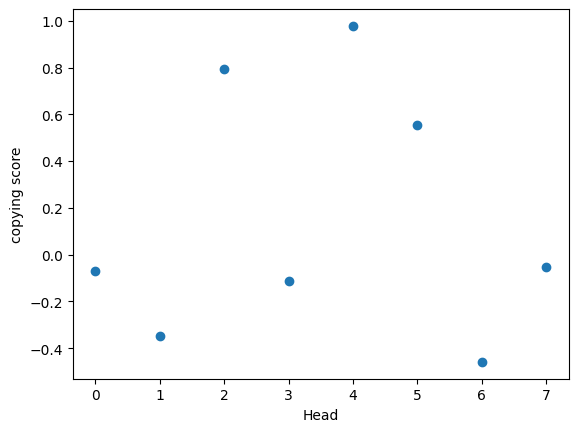

In [88]:
plt.scatter(np.arange(0,8),copying_score_np[0])
plt.xlabel('Head')
plt.ylabel('copying score')
plt.show()

In [73]:
copying_score

tensor([[-0.0705, -0.3472,  0.7917, -0.1141,  0.9778,  0.5561, -0.4587, -0.0542]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [74]:
scatter(x=eigenvalues[-1, 0, :].real, y=eigenvalues[-1, 0, :].imag, title="Eigenvalues of Head 0 of Othello-GPT", xaxis="Real", yaxis="Imaginary")

In [75]:
scatter(x=eigenvalues[-1, 4, :].real, y=eigenvalues[-1, 4, :].imag, title="Eigenvalues of Head 4 of Othello-GPT", xaxis="Real", yaxis="Imaginary")

Get the full OV circuit and the eigenvectors of it

In [89]:
full_OV_circuit = model_1L8H.embed.W_E @ W_OV @ model_1L8H.unembed.W_U
print(full_OV_circuit)

FactoredMatrix: Shape(torch.Size([1, 8, 61, 61])), Hidden Dim(64)


In [93]:
full_eigenvalues = full_OV_circuit.eigenvalues
full_copying_score = full_eigenvalues.sum(dim=-1).real / full_eigenvalues.abs().sum(dim=-1)
full_copying_score_np = full_copying_score.detach().cpu().numpy()

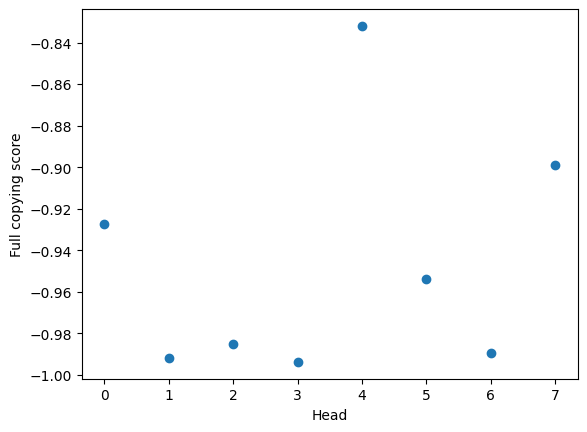

In [94]:
plt.scatter(np.arange(0,8),full_copying_score_np[0])
plt.xlabel('Head')
plt.ylabel('Full copying score')
plt.show()

In [95]:
scatter(x=full_eigenvalues[-1, 4, :].real, y=full_eigenvalues[-1, 4, :].imag, title="full Eigenvalues of Head 4 of Othello-GPT", xaxis="Real", yaxis="Imaginary")

In [100]:
W_h = full_OV_circuit.AB
W_h_np = W_h.detach().cpu().numpy()[0]


In [106]:
eig,v = np.linalg.eig(W_h_np)

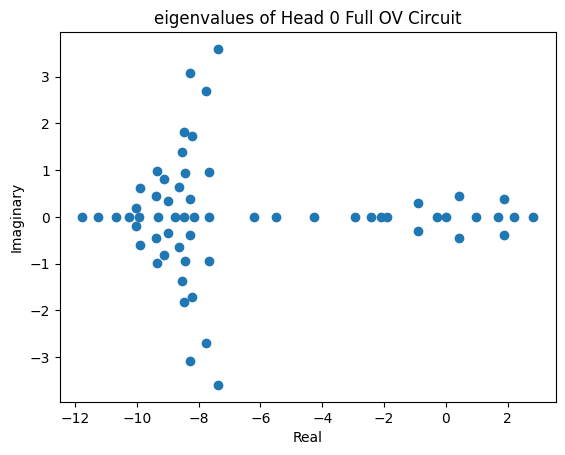

In [121]:
plt.scatter(eig[0].real,eig[0].imag)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('eigenvalues of Head 0 Full OV Circuit')
plt.show()

In [119]:
v[4,:,0]

array([ 0.06109513+0.j,  0.14146718+0.j,  0.14444095+0.j,  0.15807441+0.j,
        0.09156229+0.j,  0.06363373+0.j,  0.02808281+0.j,  0.00219046+0.j,
        0.0070985 +0.j,  0.1324689 +0.j,  0.20776105+0.j,  0.20190753+0.j,
        0.18486504+0.j,  0.09656528+0.j,  0.04354563+0.j, -0.00672137+0.j,
       -0.01673275+0.j,  0.14031523+0.j,  0.20833439+0.j,  0.21425232+0.j,
        0.11476658+0.j,  0.06466704+0.j,  0.01018093+0.j, -0.06216801+0.j,
       -0.06217237+0.j,  0.16454121+0.j,  0.2205113 +0.j,  0.15488657+0.j,
       -0.06972665+0.j, -0.1258357 +0.j, -0.10789673+0.j,  0.14660268+0.j,
        0.16929491+0.j,  0.07128209+0.j, -0.14874773+0.j, -0.2110951 +0.j,
       -0.14871173+0.j,  0.07381002+0.j,  0.09919691+0.j,  0.05505505+0.j,
       -0.00629119+0.j, -0.10218687+0.j, -0.18627752+0.j, -0.237288  +0.j,
       -0.15658201+0.j,  0.02091347+0.j,  0.03011546+0.j, -0.02981188+0.j,
       -0.07798017+0.j, -0.15251099+0.j, -0.17895739+0.j, -0.1923812 +0.j,
       -0.20121369+0.j,  

In [116]:
eig[4]

array([ 1.8848478e+00+0.j        ,  1.5508746e+00+0.j        ,
        8.1013960e-01+0.0225201j ,  8.1013960e-01-0.0225201j ,
        5.0982058e-01+0.6094175j ,  5.0982058e-01-0.6094175j ,
        3.9396033e-01+0.j        ,  3.2344559e-01+0.j        ,
       -2.8887169e+00+0.j        ,  2.8138317e-07+0.j        ,
       -8.5947201e-02+0.j        , -2.6431611e+00+0.j        ,
       -2.4915345e+00+0.j        , -2.4532251e+00+0.12503016j,
       -2.4532251e+00-0.12503016j, -6.3140887e-01+0.j        ,
       -6.8832010e-01+0.13136j   , -6.8832010e-01-0.13136j   ,
       -2.2221885e+00+0.15532944j, -2.2221885e+00-0.15532944j,
       -2.1456246e+00+0.14507557j, -2.1456246e+00-0.14507557j,
       -2.0784307e+00+0.18996622j, -2.0784307e+00-0.18996622j,
       -2.1549301e+00+0.j        , -2.1049156e+00+0.j        ,
       -2.0820415e+00+0.j        , -7.8090864e-01+0.0660502j ,
       -7.8090864e-01-0.0660502j , -1.9072095e+00+0.j        ,
       -1.8676957e+00+0.06246701j, -1.8676957e+00-0.062